We've all seen those weird looking mathematics equations that pop up when we hear about fast fourier transforms. In this blog post, we'll try and develop an intuitive understanding into the whole process. We'll try and decompose a signal into various contituent freqencies.

First, let us assume that we are doing some signal acquisition and we can sample at 100 Hz frequency (100 times per second). We collect data for 10 seconds. So, we have a total of 1000 samples. 

```python
Samples collection duration (T) = 10s
Sampling frequency (Fs) =100Hz
Number of samples (N) = Ts*Fs=1000
```

It must be noted that Fs is the rate at which we are able to sample. Let us now create a signal composed of different frequencies. 

### Code preliminaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


Let us create a simple function to generate sine and cosine waves given the time for which samples were collected, the frequency of sampling and the frequency of the desired sine wave. 

In [2]:
def create_sine(t, fs, frequency_of_sine):
    return np.sin(2*np.pi*frequency_of_sine*np.arange(0, t, 1./fs))
def create_cosine(t, fs, frequency_of_cosine):
    return np.cos(2*np.pi*frequency_of_cosine*np.arange(0, t, 1./fs))

Let us now plot a sample sine wave of 1 Hz where our instrument can sample at 100 Hz and we acquire the data for 10 seconds.  

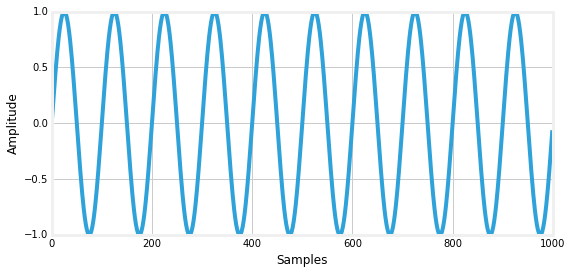

In [3]:
plt.figure(figsize=(8,4))
plt.plot(create_sine(10, 100, 1))
plt.xlabel("Samples")
plt.ylabel("Amplitude")

Great! We can see 10 time periods of our sine wave in 10 seconds. Thus, our sine wave creation functin seems to be working correct :)

### Creating the signal for processing

We will now create our dummy signal. It will be composed of four sinusoidal sine waves of different frequencies: 0 Hz, (DC), 10 Hz, 2 Hz and 0.5 Hz.

In [4]:
t = 10
fs = 100
N = t*fs
num_components = 4

components = np.zeros((num_components, N))
components[0] = np.ones(N)
components[1] = create_sine(t, fs, 10)
components[2] = create_sine(t, fs, 2)
components[3] = create_sine(t, fs, 0.5)


Plotting these four components individually.

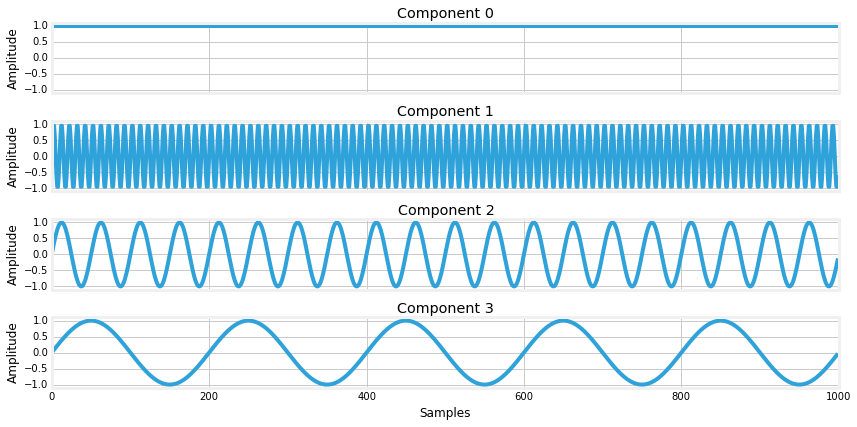

In [6]:
fig, ax  = plt.subplots(nrows=num_components, sharex=True, figsize=(12,6))
for i in range(num_components):
    ax[i].plot(components[i])
    ax[i].set_ylim((-1.1, 1.1))
    ax[i].set_title('Component {}'.format(i))
    ax[i].set_ylabel("Amplitude")
ax[num_components-1].set_xlabel("Samples")
plt.tight_layout()

Let our signal be 

$$x = -0.5\times x_0 + 0.1\times x_1 + 0.2\times x_2 -0.4\times x_3 $$

In [42]:
x = -0.5*components[0]+0.1*components[1]+0.2*components[2]-0.6*components[3]
x = components[2]

Energy of x

In [43]:
np.dot(x,x)

499.99999999999994

Our dummy signal looks something like the following

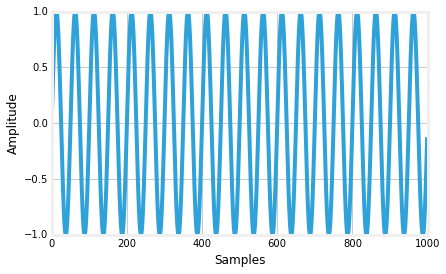

In [44]:
plt.plot(x)
plt.xlabel("Samples")
plt.ylabel("Amplitude")

By looking at the data, we might be able to notice the presence of a signal which shows five periods in 10 seconds. Or, a signal of frequency 0.5 Hz. We can also guess the presence of high frequency signals.

### Introducing DFT

For finding the various frequency components in the signal, we'll be using the Discrete Fourier Transform (DFT). The key step in DFT is to find the `correlation` between cosine waves of different frequencies with the signal that we intend to process. A high amplitude of this `correlation` indicates the presence of this frequency in our signal. 

It must be noted that the definition of `correlation` is different from the definition we encounter in statistics. Here, `correlation` between two signals simply means the dot product between the two. Please note that the dot product is the sum of the element wise product between the two signals.

We will now try and see the `correlation` between our signal and a cosine wave of different frequencies. We also create small helper functions to create sine and cosine waves containing `k` periods in `N` sample points.

In [45]:
def create_cosine_k_N(k, N):
    return np.cos((2*np.pi*k/N)*np.arange(N))
def create_sine_k_N(k, N):
    return np.sin((2*np.pi*k/N)*np.arange(N))

We already know that our signal contains a 0.5 Hz component. This component would correspond to 5 time periods in 10 seconds (N=1000 sample points). Let us see the `correlation` between this cosine and our signal `x`. 

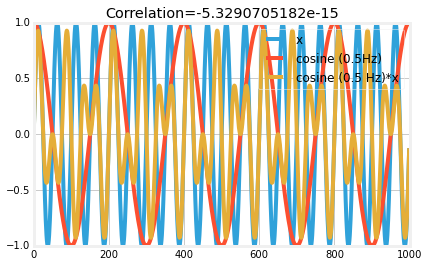

In [46]:
cos_5 = create_cosine_k_N(5,N)
plt.plot(x, label="x")
plt.plot(cos_5, label="cosine (0.5Hz)")
plt.plot(cos_5*x, label="cosine (0.5 Hz)*x")
plt.title("Correlation={}".format(np.sum(cos_5*x)))
plt.legend();

No! This correlation is so very low! But, wait a minute, how about `correlation` with the sine of the same frequency?

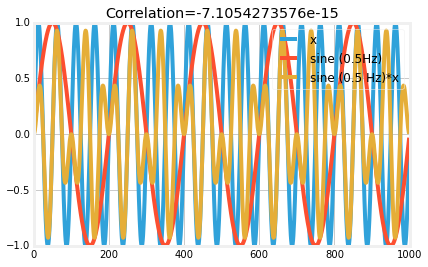

In [47]:
sin_5 = create_sine_k_N(5,N)
plt.plot(x, label="x")
plt.plot(sin_5, label="sine (0.5Hz)")
plt.plot(sin_5*x, label="sine (0.5 Hz)*x")
plt.title("Correlation={}".format(np.sum(sin_5*x)))
plt.legend();

Great! The correlation with a 0.5 Hz sinusoidal has a high amplitude. We're on to something now!
Yes, we want to detect the presence of a particular frequency and not really worry about phase for the moment. 

So, for each frequency that we find our correlation with the original signal, we can have two components- the correlation with the cosine (called the real component) and the correlation with the sine of that frequency (called the imaginary component). This is exactly what those weird looking DFT equations mean! A high absolute value of either of these components suggests the presence of that particular frequency in our signal. 

So, for every frequency in 0 to N-1 Hz, we repeat this procedure and obtain the DFT coefficients. Finally, the mathematics looks something like the following:

$ \mathrm{DFT(K)} = \sum{x_n\times \cos{\frac{2\pi K}{N}}} - \iota \sum{x_n\times \sin{\frac{2\pi K}{N}}} $

Let us repeat the procedure once again to find the presence of the 2 Hz component. For that we'll have to set K to 20. (2 Hz wave will complete 20 periods in 10 seconds).

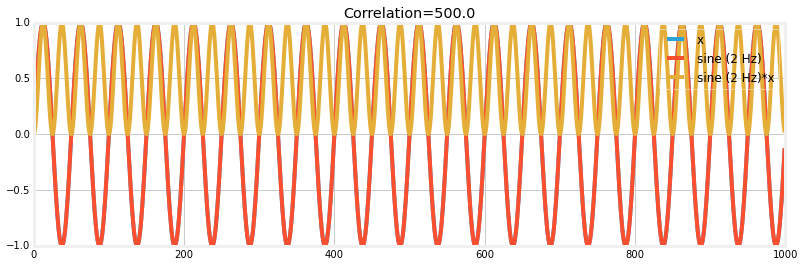

In [48]:
plt.figure(figsize=(12,4))
sin_20 = create_sine_k_N(20,N)
plt.plot(x, label="x")
plt.plot(sin_20, label="sine (2 Hz)")
plt.plot(sin_20*x, label="sine (2 Hz)*x")
plt.title("Correlation={}".format(np.sum(sin_20*x)))
plt.legend();

How about the DC component?

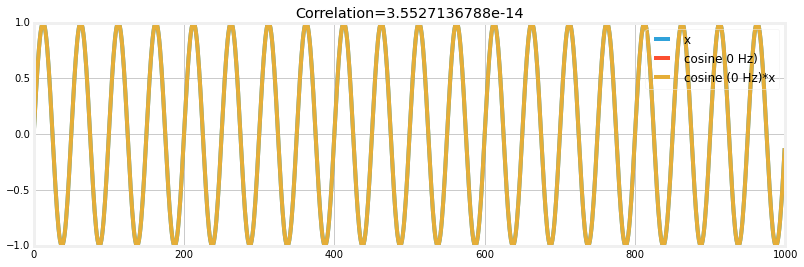

In [49]:
plt.figure(figsize=(12,4))
cos_0 = create_cosine_k_N(0,N)
plt.plot(x, label="x")
plt.plot(cos_0, label="cosine 0 Hz)")
plt.plot(cos_0*x, label="cosine (0 Hz)*x")
plt.title("Correlation={}".format(np.sum(cos_0*x)))
plt.legend();

### Using numpy's DFT implementation

Now, instead of rolling out our own implementation of DFT, we'll use the efficient inbuilt numpy DFT implementation.

In [50]:
fft_y = np.fft.fft(x)
import scipy as sp
fft_x = sp.fft(x)

So, the `fft` routine returns an array of length 1000, which is equal to the number of samples. This refers to the 1000 DFT coefficients, from K=0 to 999. But, from Nyquist criterion we know that only compnents upto fs/2 are useful. The remaining would be redundant. 

In [51]:
np.round(np.dot(abs(fft_y),abs(fft_y)))/1000

500.0

In [18]:
np.allclose(fft_x, fft_y)

True

In [19]:
len(fft_x)

1000

In [20]:
fft_x[0]

(3.5311895127199337e-14+0j)

The above was the DFT coefficient for K=0. It has two components (real and imaginary) arising from the cosine and the sine waves respectively. However, we are concerned with the amplitude of the signal. This can be done by considering the absolute value of these coefficients.

We will now plot the first 500 DFT coefficients.

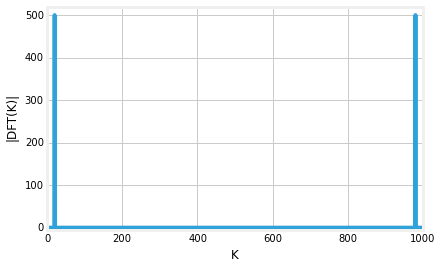

In [24]:
plt.plot(abs(fft_x)[:])
#plt.xlim((-5, 500))
plt.ylim((-5, 520))
plt.xlabel("K")
plt.ylabel("|DFT(K)|");

The above plot isn't focused enough to allow us to clearly see what's going on. So, let's restict the x axis to 120.

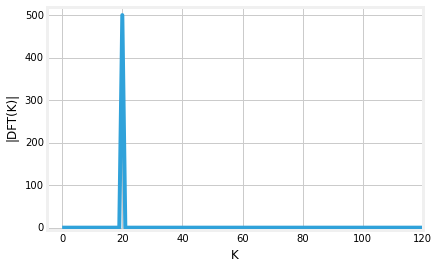

In [22]:
plt.plot(abs(fft_x)[:500])
plt.xlim((-5, 120))
plt.ylim((-5, 520))
plt.xlabel("K")
plt.ylabel("|DFT(K)|");

Ok, at K=0, 5, 20, 100, we can see spike. Now, remember that K refers to the number of periods completed in N in 10 seconds. Thus, the frequencies correpsonding to these K are: 0 Hz, 0.5 Hz, 2 Hz and 10 Hz respectively. The above plot with frequency on the x-axis would look like the following.

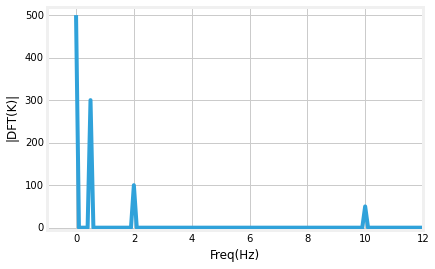

In [19]:
plt.plot(np.arange(0, 500)/10.,abs(fft_x)[:500])
plt.xlim((-1, 12))
plt.ylim((-5, 520))
plt.xlabel("Freq(Hz)")
plt.ylabel("|DFT(K)|");

### FFT of a square wave!

Can we construct a square wave from a combinations of sinusoids? Let us think the other way around. Can we decompose a square wave to get sine waves of different frequencies? Let us use our new friend's help

In [20]:
sqr_wave = np.hstack([np.ones(250), np.zeros(250), np.ones(250), np.zeros(250)])

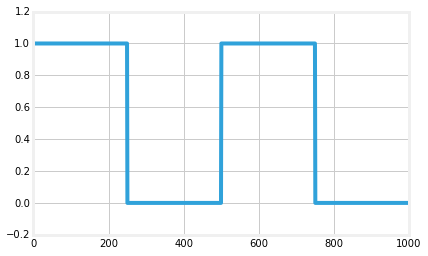

In [21]:
plt.plot(sqr_wave)
plt.ylim((-0.2,1.2));

The above is our square wave obtained under the same experimental setup as above- 100 Hz sampling for 10 seconds. Let us do a DFT on it and plot it.

In [22]:
dft_sqr = np.fft.fft(sqr_wave)

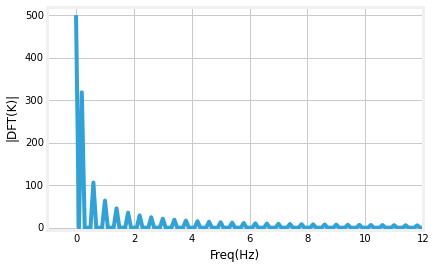

In [23]:
plt.plot(np.arange(0, 500)/10.,abs(dft_sqr)[:500])
plt.xlim((-1, 12))
plt.ylim((-5, 520))
plt.xlabel("Freq(Hz)")
plt.ylabel("|DFT(K)|");

### Taking a step further- DFT and STFT on Star wars sound

In [24]:
!wget http://www.thesoundarchive.com/starwars/swvader01.wav

--2016-01-14 19:41:30--  http://www.thesoundarchive.com/starwars/swvader01.wav
Resolving www.thesoundarchive.com (www.thesoundarchive.com)... 64.85.5.170
Connecting to www.thesoundarchive.com (www.thesoundarchive.com)|64.85.5.170|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46146 (45K) [audio/wav]
Saving to: ‘swvader01.wav.1’

swvader01.wav.1     100%[=====================>]  45.06K  34.6KB/s   in 1.3s   

2016-01-14 19:41:32 (34.6 KB/s) - ‘swvader01.wav.1’ saved [46146/46146]



In [25]:
from IPython.display import Audio

In [26]:
Audio("swvader01.wav")

In [27]:
from scipy.io.wavfile import read,write

In [28]:
fs,data = read('swvader01.wav')

In [29]:
fs

22050

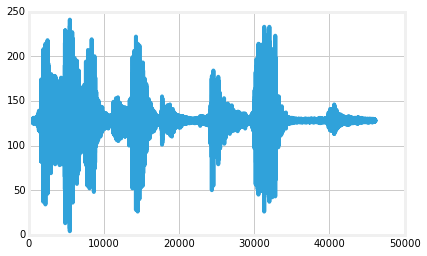

In [30]:
plt.plot(data)

In [32]:
k = np.arange(len(data))

T = len(data)/fs
T

2

Let us now plot the DFT of our sound signal.

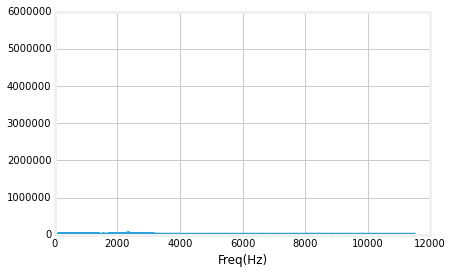

In [33]:
k = np.arange(len(data))
frq = k/T
plt.plot(frq[:len(data)/2], abs(np.fft.fft(data))[:len(data)/2])
plt.xlabel("Freq(Hz)")

Wait! We do not see anything! This is due to the fact that zero frequency or DC component dominates other components. We can work around this by subtracting the mean from the signal. 

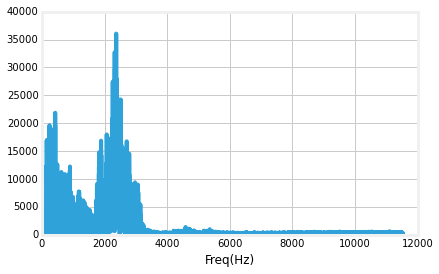

In [34]:
k = np.arange(len(data))
frq = k/T
plt.plot(frq[:len(data)/2], abs(np.fft.fft(data-np.mean(data)))[:len(data)/2])
plt.xlabel("Freq(Hz)");

Great! Now, we are able to see the frequency transform of the signal. But, do we have any idea of what frequency exists at what point in time? This is where short time fourier transform (STFT) would come into picture. Now, our goal is to not only see the frequency components, but see at what time what components exists. Turns out that to do that we have already done the basic foundation by computing the DFT. Now, we need to compute the DFT over windows of time.

Let us plot a spectogram of the data. While matplotlib provides a spectogram plot, I found the one produced in the [following](http://www.frank-zalkow.de/en/code-snippets/create-audio-spectrograms-with-python.html) tutorial more interpretable.

In [35]:
from stft_implementation import *

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


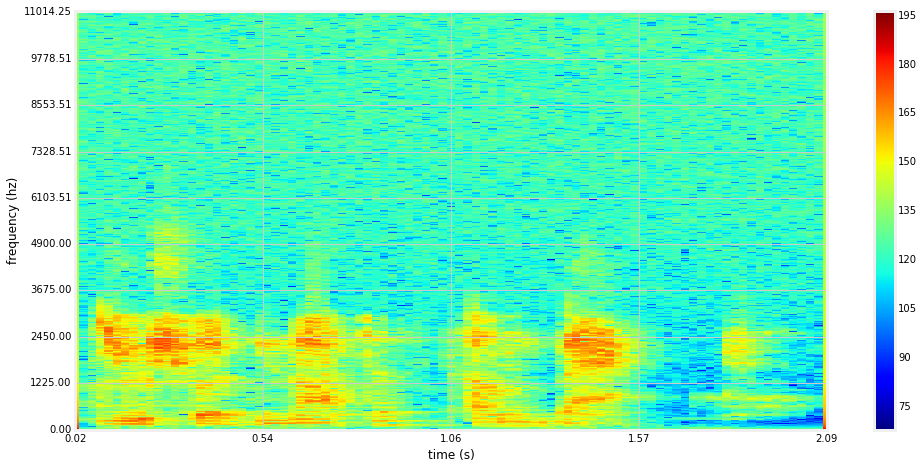

In [36]:
plotstft("swvader01.wav")

There you go! Now, does FFT sound all that difficult?

I have used a number of wonderful references for developing my understanding. I'll try and list a few here:

1. [Jake's blog post on understanding the FFT algorithm](https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/)
2. [Franks's code for spectograms](http://www.frank-zalkow.de/en/code-snippets/create-audio-spectrograms-with-python.html)
3. [Glowing Python tutorial on plotting frequency spectrum](http://glowingpython.blogspot.in/2011/08/how-to-plot-frequency-spectrum-with.html)
4. [Barry's youtube tutorial on STFT](https://www.youtube.com/watch?v=NA0TwPsECUQ)
5. [R tutorial on FFT](http://www.di.fc.ul.pt/~jpn/r/fourier/fourier.html)
6. [Interactive guide to FT](http://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/)
7. [Intuitive DFT tutorial](http://practicalcryptography.com/miscellaneous/machine-learning/intuitive-guide-discrete-fourier-transform/)
8. [David's youtube video on FFT](https://www.youtube.com/watch?v=B2iUDBZzBpY)